<a href="https://colab.research.google.com/github/CalculatedContent/ww-phys_theory/blob/master/Full_Test_Jacobians_Resnets_SVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notebook for generating Full Jacobian SVD over the test data for ResNet data

Can do the full calculation, and a batched (slow, but handles large memory cases)


```
 resnet20_cifar10
 resnet56_cifar10
 resnet110_cifar10
 resnet164bn_cifar10
 resnet272bn_cifar10

full_jacobian()


 resnet542bn_cifar10
 resnet1001_cifar10
 resnet1202_cifar10

full_batched_jacobian()

```






In [53]:
Jdir =  '/content/drive/My Drive/J_resnets_fullsvd'

thismodel = 'resnet20_cifar10'

batched = False
start_batch = 0
batch_size = 100

num_classes= 10
device = 'cuda:0'
num_data = 10000


time: 2.82 ms


In [54]:
!pip install torch==1.5.0+cu101 torchvision==0.6.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
time: 2.94 s


In [55]:
!pip install ipython-autotime
%load_ext autotime

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 2.98 s


In [56]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 2.59 ms


In [58]:
!mkdir "$Jdir"
!ls "$Jdir"

mkdir: cannot create directory ‘/content/drive/My Drive/J_resnets_fullsvd’: File exists
data				   Jfull_resnet542bn_cifar10__26.csv
Jfull_resnet1001_cifar10__0.csv    Jfull_resnet542bn_cifar10__27.csv
Jfull_resnet1001_cifar10__10.csv   Jfull_resnet542bn_cifar10__28.csv
Jfull_resnet1001_cifar10__11.csv   Jfull_resnet542bn_cifar10__29.csv
Jfull_resnet1001_cifar10__12.csv   Jfull_resnet542bn_cifar10__2.csv
Jfull_resnet1001_cifar10__13.csv   Jfull_resnet542bn_cifar10__30.csv
Jfull_resnet1001_cifar10__14.csv   Jfull_resnet542bn_cifar10__31.csv
Jfull_resnet1001_cifar10__15.csv   Jfull_resnet542bn_cifar10__32.csv
Jfull_resnet1001_cifar10__16.csv   Jfull_resnet542bn_cifar10__33.csv
Jfull_resnet1001_cifar10__17.csv   Jfull_resnet542bn_cifar10__34.csv
Jfull_resnet1001_cifar10__18.csv   Jfull_resnet542bn_cifar10__35.csv
Jfull_resnet1001_cifar10__19.csv   Jfull_resnet542bn_cifar10__36.csv
Jfull_resnet1001_cifar10__1.csv    Jfull_resnet542bn_cifar10__37.csv
Jfull_resnet1001_cifar10__20.csv   Jfull

In [59]:
!pip install pytorchcv
!pip install powerlaw
!pip install GPUtil
import GPUtil

time: 8.5 s


In [60]:
!import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Subset

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

import math
import copy

import gc


/bin/bash: import: command not found
time: 900 ms


### Run InstallPhysTheory notebook 

In [61]:
import sys
sys.path.append("/content/drive/My Drive/Jacobian")
import jacobian as jac
import utils

time: 1.97 ms


In [62]:
def jacobian_batched_full(modelname, model, data_loader, batch_size, start_batch = 0, num_classes=10, device='cuda:0', data_dim=3*32*32, formJJ=False, save=True): 
  '''Compute a full of J^{T}J Jacobian in batch mode.  '''

  model.eval() 
  model = model.to(device)

  left_data_loader = data_loader 
  right_data_loader = copy.deepcopy(data_loader)

  JJMat = None 
  for left_batch, data in enumerate(left_data_loader): 
    if left_batch < start_batch:
      continue
    print(left_batch) 

    inputs, _ = data 
    inputs = inputs.to(device)
    inputs.requires_grad=True
    outputs = model(inputs)
    J = jac.batch_diagJ(inputs, outputs)
    J = J.reshape(batch_size,num_classes*data_dim)

    X = J.detach().cpu().numpy()

    del data, inputs, outputs, J
    gc.collect()
    torch.cuda.empty_cache()
    GPUtil.showUtilization()

    JJBlock = None
    for right_batch, data in enumerate(right_data_loader):
      print(left_batch, right_batch)
      inputs, _ = data 
      inputs = inputs.to(device)
      inputs.requires_grad=True
      outputs = model(inputs)
    
      Jt = jac.batch_diagJ(inputs, outputs)
      Jt = Jt.reshape(batch_size,num_classes*data_dim)

      Xt = Jt.detach().cpu().numpy().transpose()

      del data, inputs, outputs, Jt
      gc.collect()
      torch.cuda.empty_cache()

      block = np.dot(X,Xt)
      JJBlock = np.hstack([JJBlock, block]) if JJBlock is not None else block

    # end of right_batch loop
    
    if save:
      filename = "{}/Jfull_{}__{}.csv".format(Jdir, modelname, left_batch)
      np.savetxt(filename, JJBlock, delimiter='\t')
      print("Saved file ",filename)

    if formJJ:
      JJMat = np.vstack([JJMat, JJBlock]) if JJMat is not None else JJBlock

      print("JJMat shape ", left_batch, JJMat.shape, filename) 

  # end of left_batch loop

  return JJMat


time: 51.9 ms


In [64]:
def jacobian_full(model, data_loader, batch_size, num_classes=10, device='cuda:0'): 
  '''compute a full of J^{T}J Jacobian directly.  '''

  model.eval()
  model = model.to(device)

  J_right = jac.construct_diagJ(model, test_loader, batch_size=batch_size, device=device) 
  J_left = J_right.transpose(1,0)
  JJ = torch.mm(J_right, J_left)
  JJMat = JJ.detach().cpu().numpy()

  del J_right, J_left, JJ
  gc.collect()
  torch.cuda.empty_cache()

  return JJMat

time: 6.2 ms


### ResNet 

In [65]:
import pytorchcv
from pytorchcv.model_provider import get_model as ptcv_get_model

time: 1.21 ms


### Compute JJ, in batches or all at once


In [67]:
print(thismodel)
train_dataset, test_dataset, train_loader, test_loader = utils.get_data(batch_size=batch_size)

model = ptcv_get_model(thismodel, pretrained=True)  
if batched: 
  jacobian_batched_full(thismodel, model, test_loader, batch_size=batch_size, start_batch=start_batch)
else:
  JJMat = jacobian_full(model, test_loader, batch_size=batch_size)


resnet20_cifar10
Files already downloaded and verified
Files already downloaded and verified
time: 16.1 s


In [68]:
if batched:
  print("Reading batched JJBlocks for ", thismodel)
  JJMat = None
  import os, glob
  os.chdir(Jdir)
  for filename in glob.glob("Jfull_resnet542bn_cifar10*"):
    print(filename)
    JJBlock = np.loadtxt(filename)
    JJMat = np.vstack([JJMat, JJBlock]) if JJMat is not None else JJBlock


time: 3.31 ms


Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


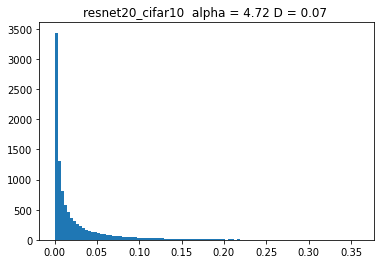

time: 7min 2s


In [69]:
import powerlaw
norm = 10*3*32*32
evals = np.linalg.eigvals(JJMat)
evals  = (1.0/ norm)*evals

fit = powerlaw.Fit(evals)
alpha = fit.alpha
D = fit.D

plt.hist(evals, bins=100)
plt.title("{}  alpha = {:0.2f} D = {:0.2f} ".format(thismodel, alpha, D))
plt.show()
